In [3]:
from matplotlib import pyplot as plt
from numpy import arange

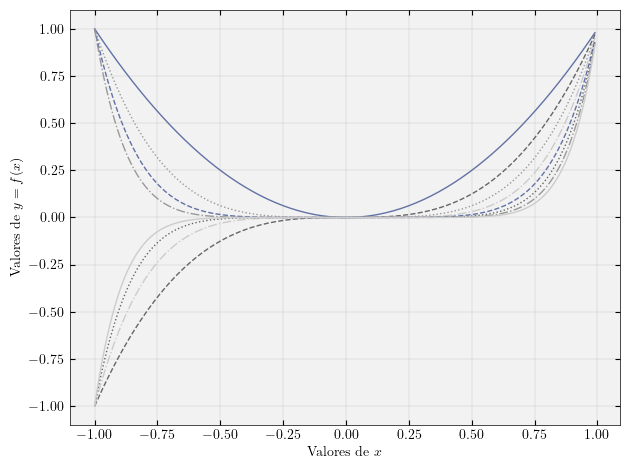

In [4]:
plt.style.use("duarte.mplstyle")
t = arange(-1,1,0.01)

fig, ax = plt.subplots()

for k in range(2,10):
    ax.plot(t, t**k, label=f"$f(x) = x^{k}$")
ax.set_xlabel("Valores de $x$")
ax.set_ylabel("Valores de $y = f(x)$")
fig.tight_layout()
plt.show()